<a href="https://colab.research.google.com/github/BrauuHdzM/BERT-For-Sequence-Classification/blob/master/DaVincisBERTst2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import BertTokenizer, BertModel, TrainingArguments, Trainer
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch

# Corpus
text_filepath = "/content/train_data.csv"
labels_filepath = "/content/train_labels_subtask_2.csv"

text_data = pd.read_csv(text_filepath, usecols=[1], header=None)
train_texts, test_texts = train_test_split(text_data.iloc[:, 0].tolist(), test_size=0.1, random_state=0)

labels_data = pd.read_csv(labels_filepath, header=None)
labels_data = labels_data.values
train_labels, test_labels = train_test_split(labels_data, test_size=0.1, random_state=0) # Tokenización y codificación del corpus de entrenamiento y pruebas

print(labels_data)
print(f'Length of text_data: {len(text_data)}')
print(f'Length of labels_data: {len(labels_data)}')

[[0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Length of text_data: 2996
Length of labels_data: 2996


In [ ]:
# Tokenización y codificación del corpus de entrenamiento y pruebas
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Carga del modelo preentrenado y ajuste fino
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=4)

training_args = TrainingArguments(
    output_dir='./test_trainer',
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Epoch,Training Loss,Validation Loss
1,No log,0.155355
2,0.164200,0.155076
3,0.047800,0.163157


TrainOutput(global_step=1011, training_loss=0.10496288608726478, metrics={'train_runtime': 251.6841, 'train_samples_per_second': 32.136, 'train_steps_per_second': 4.017, 'total_flos': 623461063305600.0, 'train_loss': 0.10496288608726478, 'epoch': 3.0})

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.65      0.83      0.73        18
           2       0.78      0.88      0.82        16
           3       0.96      0.91      0.93       174

   micro avg       0.92      0.92      0.92       307
   macro avg       0.83      0.89      0.86       307
weighted avg       0.92      0.92      0.92       307
 samples avg       0.92      0.92      0.92       307



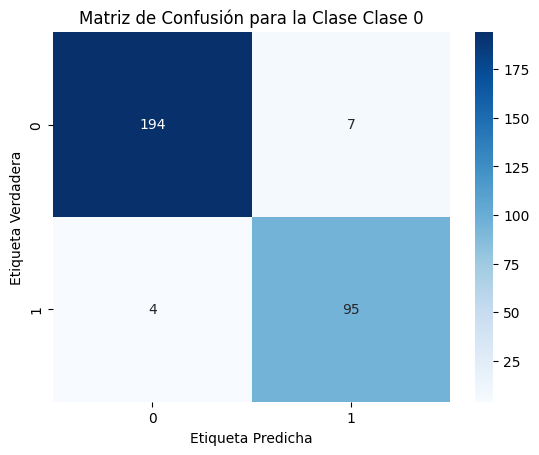

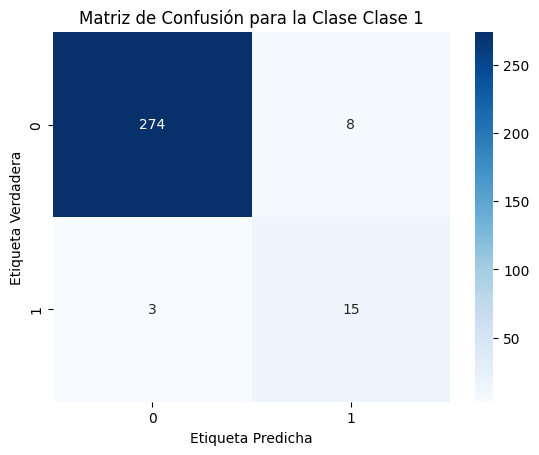

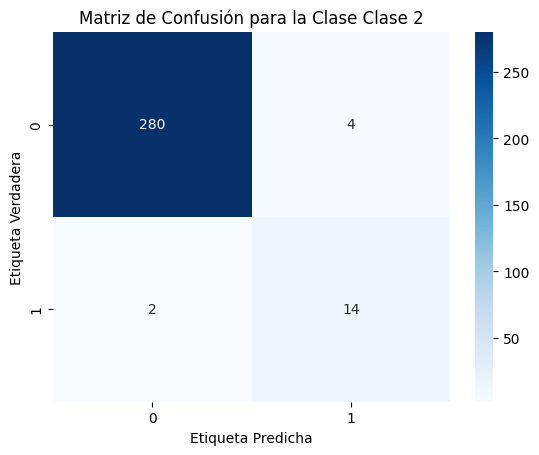

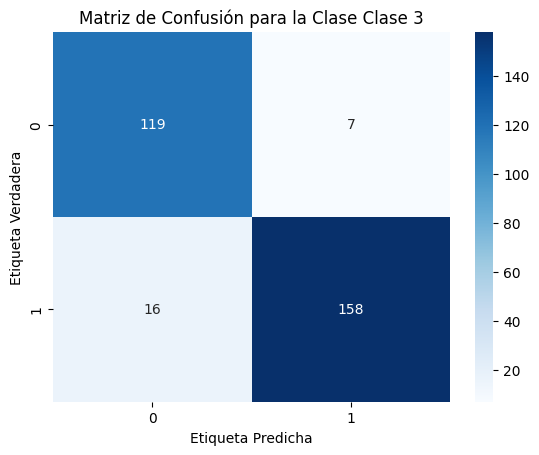

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Predecir en el conjunto de prueba
predictions = trainer.predict(test_dataset)

# Las predicciones están en formato logit, así que las convertimos a clases usando una función de umbral
predicted_classes = (torch.sigmoid(torch.from_numpy(predictions.predictions)) > 0.5).numpy()

# Classification report
report = classification_report(test_labels, predicted_classes)
print(report)

# Matrices de confusión
confusion_matrices = multilabel_confusion_matrix(test_labels, predicted_classes)
class_labels = ["Clase 0", "Clase 1", "Clase 2", "Clase 3"]

# Graficar cada matriz de confusión
for i, matrix in enumerate(confusion_matrices):
    plt.figure()
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión para la Clase {class_labels[i]}")
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Verdadera")
    plt.show()